#**Entrenamiento MobileNetV3Large**
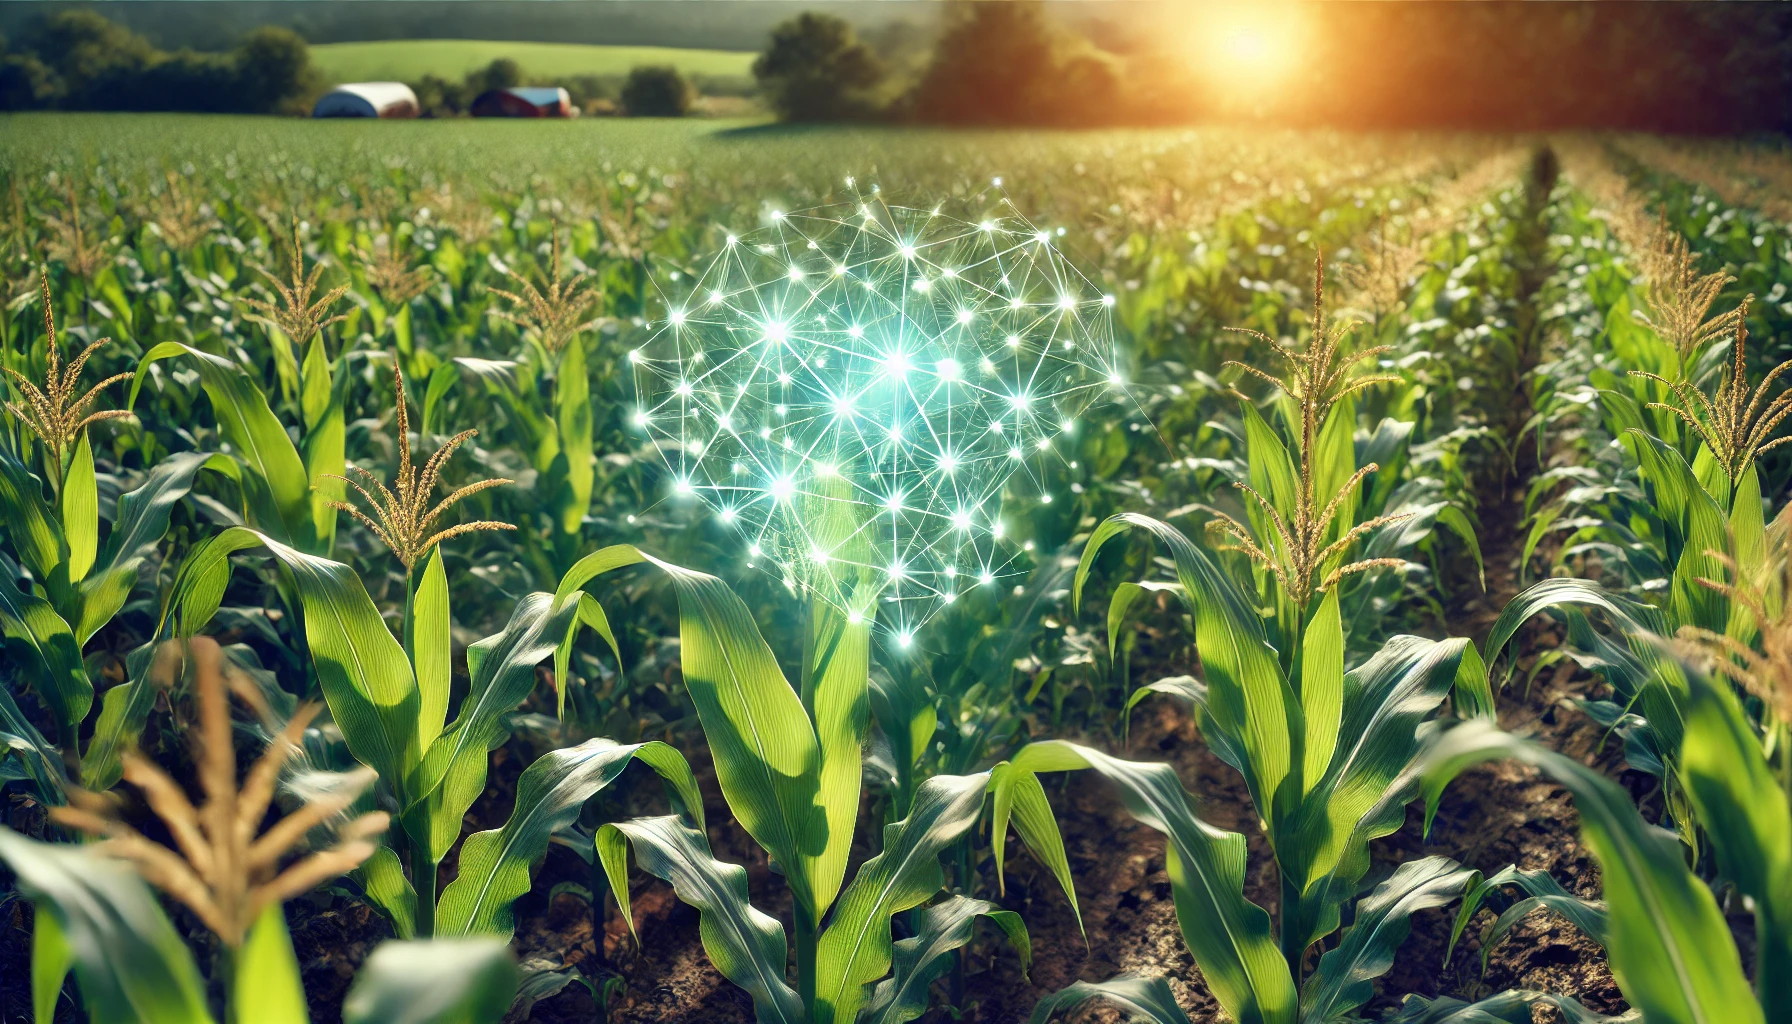

El presente notebook fue desarrollado con el objetivo de entrenar una red MobileNetV3-Large basada en aprendizaje supervisado, orientada a la detección y clasificación de enfermedades foliares en cultivos de maíz —específicamente roya común, mancha gris y tizón foliar—, así como a la identificación de plantas sanas.
El modelo se entrena considerando la necesidad de obtener una arquitectura compacta y eficiente, dado que el propósito final es su implementación en dispositivos de borde.
Cabe señalar que las etapas de optimización del modelo para su despliegue en el borde (como poda y cuantización) se desarrollan en un notebook independiente.

**NOTA:**
Se recomienda ejecutar este notebook en Google Colab utilizando una GPU L4, con el fin de optimizar el rendimiento y reducir significativamente el tiempo de entrenamiento del modelo.

In [ ]:
# ==========================================
# IMPORTE DE LIBRERIAS
# ==========================================
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models



## **Configuración de GPU**
Dado que este notebook fue diseñado para su ejecución en Google Colab, el siguiente bloque tiene como objetivo optimizar el uso de los recursos de GPU proporcionados por este entorno.

In [ ]:
# ==========================================
# CONFIGURACIÓN GPU - VERIFICAR Y OPTIMIZAR
# ==========================================
print("Verificando configuración GPU...")

# Verificar si hay GPU disponible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detectada: {gpus[0].name}")
    # Configurar crecimiento de memoria para mejor uso de GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se detectó GPU, usando CPU.")

# Configurar estrategia para múltiples GPUs (si hay)
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Usando {len(gpus)} GPUs con MirroredStrategy")
else:
    strategy = tf.distribute.get_strategy()
    print("Usando estrategia por defecto")

Verificando configuración GPU...
GPU detectada: /physical_device:GPU:0
Usando estrategia por defecto


## **Configuración Experimento**
Este bloque define los parámetros generales de configuración utilizados durante el entrenamiento del modelo.
Permite centralizar los valores clave del experimento, facilitando su ajuste y manteniendo la reproducibilidad.
En este diccionario se especifican:

*   DATA_DIR: ruta donde se almacena el conjunto de datos en Google Drive.
*   IMG_SIZE: tamaño de las imágenes que se usarán como entrada al modelo (224x224 píxeles).
*   BATCH_SIZE: cantidad de imágenes procesadas por lote durante el entrenamiento.

*   EPOCHS: número total de iteraciones completas sobre el conjunto de datos.


*   LEARNING_RATE: tasa de aprendizaje inicial del optimizador.

In [ ]:
# ===============
# CONFIGURACIÓN
# ===============

CONFIG = {
    "DATA_DIR": "/content/drive/MyDrive/data",
    "IMG_SIZE": (224, 224), #tamaño compatible con la arquitectura MobileNetV3
    "BATCH_SIZE": 64,
    "EPOCHS": 15,
    "LEARNING_RATE": 1e-4
}

print(f"\n Configuración:")
print(f"- Batch size: {CONFIG['BATCH_SIZE']}")
print(f"- Image size: {CONFIG['IMG_SIZE']}")
print(f"- Epochs: {CONFIG['EPOCHS']}")
print(f"- Learning Rate: {CONFIG['LEARNING_RATE']}")



 Configuración:
- Batch size: 64
- Image size: (224, 224)
- Epochs: 15
- Learning Rate: 0.0001


## **Carga de Datos**
Este bloque realiza la carga y preparación de los conjuntos de datos de entrenamiento, validación y prueba, empleando la siguiente estructura.


1.   Conecta Google Drive para acceder a los datos almacenados en la ruta definida en CONFIG["DATA_DIR"].
2.  Utiliza la función `image_dataset_from_directory` de TensorFlow para cargar las imágenes y etiquetas desde las carpetas correspondientes, aplicando el tamaño de imagen y tamaño de lote configurados previamente.
3. Extrae y muestra las clases detectadas para verificar la correcta lectura de los datos.
4. Optimiza los datasets mediante la técnica `prefetch`, que permite aprovechar mejor la GPU al solapar la carga de datos con su procesamiento, reduciendo así los tiempos de entrenamiento.

En síntesis, este bloque prepara de forma eficiente los datos para que el modelo pueda entrenarse de manera fluida en entornos con GPU.

In [ ]:
# ==========================================
# 1. CARGAR DATOS CON OPTIMIZACIÓN GPU
# ==========================================
from google.colab import drive # solo necesario si tienen los dataset en el drive
# conectar con drive
drive.mount('/content/drive') # solo necesario si tienen los dataset en el drive

print("\n Cargando y optimizando datasets...")

# Cargar datasets y guardar class_names ANTES de optimizar
train_ds_original = image_dataset_from_directory(
    os.path.join(CONFIG["DATA_DIR"], "train"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    label_mode='int'
)

val_ds_original = image_dataset_from_directory(
    os.path.join(CONFIG["DATA_DIR"], "val"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    label_mode='int'
)

test_ds_original = image_dataset_from_directory(
    os.path.join(CONFIG["DATA_DIR"], "test"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    label_mode='int'
)

# GUARDAR class_names ANTES de optimizar
class_names = train_ds_original.class_names
print(f"Clases detectadas: {class_names}")

# OPTIMIZAR DATASETS PARA GPU (conservando referencias originales)
AUTOTUNE = tf.data.AUTOTUNE

def optimize_dataset(dataset):
    return dataset.prefetch(buffer_size=AUTOTUNE)

train_ds = optimize_dataset(train_ds_original)
val_ds = optimize_dataset(val_ds_original)
test_ds = optimize_dataset(test_ds_original)

print(f"Estadísticas de datasets:")
print(f"- Train: {len(list(train_ds_original)) * CONFIG['BATCH_SIZE']} imágenes")
print(f"- Validation: {len(list(val_ds_original)) * CONFIG['BATCH_SIZE']} imágenes")
print(f"- Test: {len(list(test_ds_original)) * CONFIG['BATCH_SIZE']} imágenes")
print(f"- Train batches: {len(list(train_ds_original))}")
print(f"- Val batches: {len(list(val_ds_original))}")
print(f"- Test batches: {len(list(test_ds_original))}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Cargando y optimizando datasets...
Found 6955 files belonging to 4 classes.
Found 1488 files belonging to 4 classes.
Found 1488 files belonging to 4 classes.
Clases detectadas: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Estadísticas de datasets:
- Train: 6976 imágenes
- Validation: 1536 imágenes
- Test: 1536 imágenes
- Train batches: 109
- Val batches: 24
- Test batches: 24


## **Creación del Modelo**
Este bloque define y construye la arquitectura mejorada del modelo de clasificación utilizando la red preentrenada MobileNetV3Large como base.


1.   **Estrategia de distribución:**
      El modelo se crea dentro del contexto `strategy.scope()`, lo que permite aprovechar múltiples GPU o TPU para el entrenamiento distribuido, asegurando sincronización adecuada entre los dispositivos.

2.   **Modelo base:**
      Se carga `MobileNetV3Large` con pesos preentrenados en ImageNet y sin la capa superior (include_top=False). Esta red actúa como extractor de características eficiente y ligero, optimizado para dispositivos móviles.

3.   **Congelación de pesos:**
      Inicialmente, se congelan las capas del modelo base (`trainable=False`) para preservar el conocimiento aprendido durante el preentrenamiento, entrenando únicamente las capas añadidas posteriormente.

4.  **Capas superiores personalizadas:**
      Se añaden capas densas y de normalización para mejorar la capacidad de generalización:
    * Dense(512, relu) + BatchNormalization + Dropout(0.5)
    * Dense(256, relu) + BatchNormalization + Dropout(0.3)
    * Capa final Dense(4, softmax) para clasificar en 4 categorías.
    
5.  **Compilación:**
      El modelo se compila con el optimizador Adam y una tasa de aprendizaje definida en la configuración (`CONFIG["LEARNING_RATE"]`), usando la función de pérdida `sparse_categorical_crossentropy` y la métrica de precisión (`accuracy`).

In [ ]:
# =================
# 2. CREAR MODELO
# =================
print("\n Creando modelo mejorado...")

def create_improved_model():
    with strategy.scope():  # DENTRO DE ESTRATEGIA PARA MULTI-GPU
        # Cargar base model
        base_model = MobileNetV3Large(
            input_shape=CONFIG["IMG_SIZE"] + (3,),
            include_top=False,
            weights="imagenet",
            pooling='avg'
        )

        # Congelar inicialmente
        base_model.trainable = False


        model = models.Sequential([
            base_model,
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(4, activation='softmax')
        ])

        # Compilar
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["LEARNING_RATE"]),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Crear modelo
model = create_improved_model()

print("Modelo creado y compilado dentro de estrategia GPU")
model.summary()



 Creando modelo mejorado...
Modelo creado y compilado dentro de estrategia GPU


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,623,812 (13.82 MB)

 Trainable params: 625,924 (2.39 MB)

 Non-trainable params: 2,997,888 (11.44 MB)

## **Callbacks Para Optimización y Control del Entrenamiento**
En este bloque se definen y configuran los *callbacks* utilizados durante el entrenamiento del modelo. Los callbacks permiten controlar dinámicamente el proceso de entrenamiento, mejorando la eficiencia, la estabilidad y la capacidad de generalización del modelo.


1.   **Creación de directorio:**
      Se crea el directorio `/content/checkpoints` para almacenar los puntos de control (model checkpoints) correspondientes a las mejores versiones del modelo entrenado.
2.   **EarlyStopping:**
      Detiene el entrenamiento de forma anticipada si la pérdida de validación (`val_loss`) no mejora tras un número determinado de épocas (patience=3).
      Además, `restore_best_weights=True` asegura que se recuperen los pesos del modelo con el mejor rendimiento alcanzado.
3.   **ReduceLROnPlateau:**
      Reduce automáticamente la tasa de aprendizaje (`learning rate`) cuando la pérdida de validación deja de mejorar (patience=3).
      El factor 0.5 indica que la tasa se reduce a la mitad en cada ajuste, con un límite mínimo de 1e-7. Esto ayuda a refinar el aprendizaje en etapas avanzadas del entrenamiento.
4.   **ModelCheckpoint:**
      Guarda el modelo cada vez que se logra una mejora en la precisión de validación (`val_accuracy`). Los modelos se almacenan con un nombre que indica la época correspondiente (`best_model_epoch_{epoch:02d}.keras`), facilitando el análisis posterior del entrenamiento.

En conjunto, estos callbacks permiten:


*   Prevenir sobreentrenamiento (EarlyStopping)
*   Ajustar dinámicamente la tasa de aprendizaje (ReduceLROnPlateau)
*   Conservar los mejores pesos obtenidos (ModelCheckpoint)

Esto contribuye a un proceso de entrenamiento más estable, eficiente y reproducible.

In [ ]:
# ==============
# 3. CALLBACKS
# ==============
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Crear directorio para checkpoints
os.makedirs('/content/checkpoints', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/checkpoints/best_model_epoch_{epoch:02d}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

## **Entrenamiento Fase 1**
En esta fase inicial, se entrena únicamente la parte superior del modelo (clasificador), manteniendo congeladas las capas del modelo base `MobileNetV3Large` previamente preentrenado en ImageNet.

Este enfoque permite adaptar las capas finales a la nueva tarea de clasificación sin alterar los pesos de las capas convolucionales, conservando así el conocimiento general previamente aprendido.

Se utiliza un número reducido de épocas, ya que el objetivo es ajustar la nueva cabeza del modelo antes de proceder al fine-tuning de las capas profundas en fases posteriores.

In [ ]:
# ==================================================
# 4. ENTRENAR PRIMERA FASE (MODELO BASE CONGELADO)
# ==================================================
print("\n FASE 1: Entrenando con base congelado...")

history1 = model.fit(
    train_ds,
    epochs=5,  # Primera fase corta
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)


 FASE 1: Entrenando con base congelado...
Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5705 - loss: 1.2178
Epoch 1: val_accuracy improved from -inf to 0.88777, saving model to /content/checkpoints/best_model_epoch_01.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 500ms/step - accuracy: 0.5718 - loss: 1.2139 - val_accuracy: 0.8878 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8630 - loss: 0.3667
Epoch 2: val_accuracy improved from 0.88777 to 0.93750, saving model to /content/checkpoints/best_model_epoch_02.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8632 - loss: 0.3663 - val_accuracy: 0.9375 - val_loss: 0.1830 - learning_rate: 1.0000e-04
Epoch 3/5
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9039 - loss: 0.2610
Epoch 3: val_accuracy improved from 0.93750 to 0.94758, saving model to /content/checkpoints/best_model_epoch_03.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - 

## **Entrenamiento Fase 2**
En esta segunda fase se realiza el fine-tuning del modelo, un proceso que consiste en descongelar progresivamente las capas superiores de la red base `MobileNetV3Large` para permitir su ajuste fino al dominio específico de las enfermedades foliares del maíz.

Inicialmente, solo se reentrenan las capas más profundas (a partir de la capa 100) mientras se mantienen congeladas las capas iniciales para preservar las características generales aprendidas durante el preentrenamiento en ImageNet.

Además, se reduce la tasa de aprendizaje en un orden de magnitud (÷10) con el fin de evitar grandes actualizaciones de pesos que puedan degradar la representación previamente aprendida.

Esta fase permite mejorar la precisión del modelo adaptando las representaciones visuales a las particularidades del nuevo conjunto de datos.

In [ ]:
# ==========================================
# 5. FINE-TUNING (DESCONGELAR CAPAS)
# ==========================================
print("\n FASE 2: Fine-tuning (descongelando capas)...")

# Descongelar el base model para fine-tuning
model.layers[0].trainable = True

# Fine-tune solo las últimas capas del base model
fine_tune_at = 100  # Ajustar según sea necesario
for layer in model.layers[0].layers[:fine_tune_at]:
    layer.trainable = False

print(f"Capas entrenables después de fine-tuning: {sum([l.trainable for l in model.layers[0].layers])}/{len(model.layers[0].layers)}")

# Recompilar con learning rate más bajo
with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["LEARNING_RATE"]/10),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

# Entrenar segunda fase
history2 = model.fit(
    train_ds,
    epochs=CONFIG["EPOCHS"],
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)


 FASE 2: Fine-tuning (descongelando capas)...
Capas entrenables después de fine-tuning: 88/188
Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8428 - loss: 0.4490
Epoch 1: val_accuracy did not improve from 0.96909
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 385ms/step - accuracy: 0.8430 - loss: 0.4485 - val_accuracy: 0.9590 - val_loss: 0.1167 - learning_rate: 1.0000e-05
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8995 - loss: 0.2804
Epoch 2: val_accuracy did not improve from 0.96909
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.8995 - loss: 0.2802 - val_accuracy: 0.9536 - val_loss: 0.1335 - learning_rate: 1.0000e-05
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9201 - loss: 0.2288
Epoch 3: val_accuracy did not improve from 0.96909
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9201 - loss: 0.2287 - val_accuracy: 0.9583 - val_loss: 0.1256 - learning_rate: 1.0000e-05
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 

## **Evaluación**
En esta fase se evalúa el desempeño final del modelo sobre el conjunto de pruebas (test set), el cual no fue utilizado durante el entrenamiento ni la validación, garantizando una estimación objetiva de su capacidad de generalización.

Se calcula el "accuracy" (precisión), que permiten determinar el rendimiento global del modelo en datos completamente nuevos. Estos resultados son fundamentales para comparar el modelo con futuras versiones optimizadas (por ejemplo, después de aplicar poda o cuantización).


In [ ]:
# ==========================================
# 6. EVALUACIÓN FINAL CON MÉTRICAS DETALLADAS
# ==========================================
print("\n Evaluación final en test set...")

# Evaluar en test set
test_loss,test_accuracy = model.evaluate(test_ds, verbose=0)

print(f"\n RESULTADOS FINALES:")
print(f"- Test Accuracy: {test_accuracy:.4f}")


 Evaluación final en test set...

 RESULTADOS FINALES:
- Test Accuracy: 0.9241


## **Evaluación Grafica**
En esta sección se visualiza la evolución del rendimiento del modelo durante el proceso de entrenamiento y fine-tuning, combinando los historiales de ambas fases.
Se generan dos gráficos:
   

1.   **Accuracy:**
      muestra la evolución de la precisión tanto en entrenamiento como en validación, permitiendo observar el punto donde se inicia el fine-tuning (línea roja discontinua) y la estabilidad del modelo a lo largo de las épocas.
2.   **Loss:**
      representa la variación de la función de pérdida (loss) para entrenamiento y validación, útil para identificar posibles signos de sobreajuste (overfitting) o inestabilidad en el aprendizaje.

Estas visualizaciones permiten analizar de forma intuitiva el impacto de la segunda fase (fine-tuning) sobre la convergencia y el desempeño general del modelo.


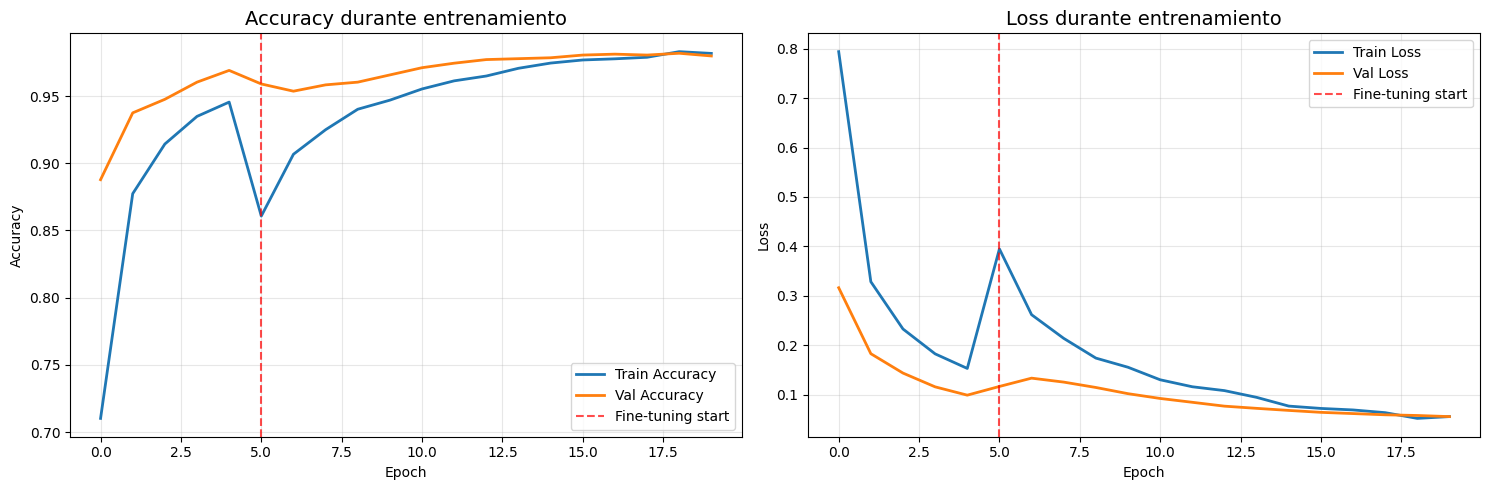

In [ ]:
# ==========================================
# 7. GRÁFICAS DE EVOLUCIÓN
# ==========================================
plt.figure(figsize=(15, 5))

# Combinar historiales
combined_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss']
}

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.axvline(x=len(history1.history['accuracy']), color='r', linestyle='--',
            label='Fine-tuning start', alpha=0.7)
plt.title('Accuracy durante entrenamiento', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss', linewidth=2)
plt.plot(combined_history['val_loss'], label='Val Loss', linewidth=2)
plt.axvline(x=len(history1.history['loss']), color='r', linestyle='--',
            label='Fine-tuning start', alpha=0.7)
plt.title('Loss durante entrenamiento', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Evaluación en Test**
En esta sección se realiza la evaluación cualitativa y cuantitativa del modelo sobre el conjunto de prueba. El objetivo es analizar el desempeño final mediante la generación de métricas e interpretaciones visuales.

**Proceso:**
1. Se recorren todos los lotes del conjunto de prueba (test_ds) para recolectar las predicciones del modelo y las etiquetas reales, almacenándolas en listas para su posterior análisis.
2. Se calcula la exactitud (accuracy) global en el conjunto de prueba, lo que permite contrastar los resultados obtenidos durante el entrenamiento con el desempeño final.
3. Se genera una matriz de confusión, representada mediante un mapa de calor (heatmap), donde se observan los aciertos y errores de clasificación por clase.
4. Finalmente, se imprime el reporte de clasificación, que incluye métricas detalladas por clase (precision, recall y F1-score), facilitando la identificación de posibles sesgos o clases más difíciles.

Estas métricas y visualizaciones proporcionan una visión integral del rendimiento del modelo, permitiendo evaluar su capacidad de generalización y su viabilidad para la implementación en dispositivos de borde.



 Analizando predicciones...
Recolectando predicciones...
 Accuracy final en test: 0.9241


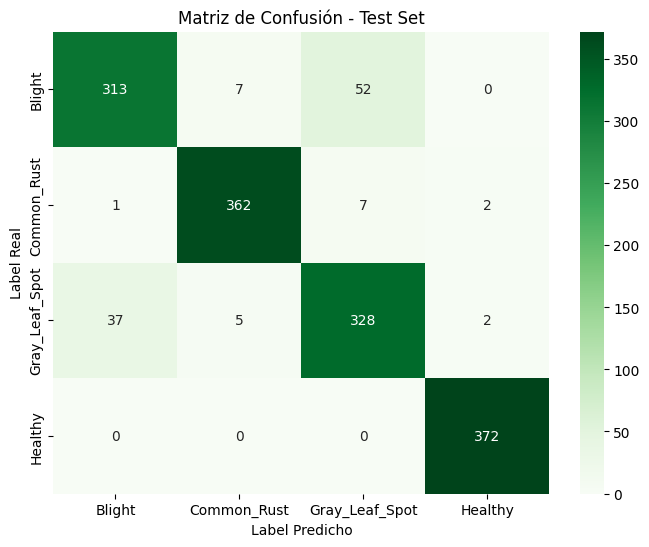


 Reporte de Clasificación Detallado:
                precision    recall  f1-score   support

        Blight       0.89      0.84      0.87       372
   Common_Rust       0.97      0.97      0.97       372
Gray_Leaf_Spot       0.85      0.88      0.86       372
       Healthy       0.99      1.00      0.99       372

      accuracy                           0.92      1488
     macro avg       0.92      0.92      0.92      1488
  weighted avg       0.92      0.92      0.92      1488



In [ ]:
# ==========================================
# 8. PREDICCIONES DE EJEMPLO Y MÉTRICAS
# ==========================================
print("\n Analizando predicciones...")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Recolectar todas las predicciones y labels
all_preds = []
all_labels = []

print("Recolectando predicciones...")
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    all_preds.extend(pred_classes)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calcular accuracy global
final_accuracy = np.mean(all_preds == all_labels)
print(f" Accuracy final en test: {final_accuracy:.4f}")

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión - Test Set')
plt.ylabel('Label Real')
plt.xlabel('Label Predicho')
plt.show()

# Reporte de clasificación
print("\n Reporte de Clasificación Detallado:")
print(classification_report(all_labels, all_preds,
                          target_names=class_names))

## **Rendimiento del Modelo**
Esta sección buscar servir como punto de control final presentando un resumen final del rendimiento del modelo, incluyendo la precisión obtenida tras el entrenamiento.
Se define un umbral de desempeño esperado (accuracy > 0.85) y se comparan los resultados alcanzados. Además, se incluyen posibles causas de bajo rendimiento en caso de que la precisión no cumpla el objetivo, como el desbalance de clases o el sobreajuste (overfitting).

In [ ]:
# ==========================================
# 9. INFORMACIÓN DE RENDIMIENTO GPU
# ==========================================
print("\n INFORMACIÓN DE RENDIMIENTO:")
print(f"Entrenamiento completado con GPU")
print(f"Accuracy objetivo: > 0.85")
print(f"Accuracy alcanzado: {final_accuracy:.4f}")

if final_accuracy < 0.70:
    print("\n  El accuracy es bajo. Posibles causas:")
    print("   - Desbalance de clases")
    print("   - Overfitting")
    print("   - Datos de test muy diferentes")
    print("   - Necesita más entrenamiento")
elif final_accuracy >= 0.85:
    print("\n ¡Excelente! Modelo superó el objetivo")
else:
    print("\n ¡Modelo entrenado exitosamente!")

print("\n ¡PROCESO COMPLETADO!")


 INFORMACIÓN DE RENDIMIENTO:
Entrenamiento completado con GPU
Accuracy objetivo: > 0.85
Accuracy alcanzado: 0.9241

 ¡Excelente! Modelo superó el objetivo

 ¡PROCESO COMPLETADO!


## **Almacenamiento de Modelo**
Finalmente, basados en el análisis de las métricas podemos proceder a almacenar el modelo en formato `.keras,` con el fin de proseguir a la siguiente etapa

In [ ]:
# ==========================================
# 10. GUARDAR MODELO FINAL
# ==========================================
final_model_path = '/content/modelo_final_mejorado.keras'
model.save(final_model_path)
print(f"Modelo guardado en: {final_model_path}")

Modelo guardado en: /content/modelo_final_mejorado_2.keras
